## Reading a WDM and Writing to HDF5
+ **Entire WDM is Read and Written to HDF5 File (our prefered database)**
+ **You Can View the HDF5 file with HDFView or HDFCompass**


In [5]:
from readWDM import read_WDM

from versioninfo import versions
versions(['numba', 'numpy', 'pandas', 'tables'])

import matplotlib.pyplot as m_plt

For convenience, this is a copy of the file readWDM:

In [6]:
import numpy as np
import pandas as pd
from numba import jit

# look up attributes NAME, data type (Integer; Real; String) and data length by attribute number
attrinfo = {1:('TSTYPE','S',4),     2:('STAID','S',16),    11:('DAREA','R',1),
           17:('TCODE','I',1),     27:('TSBYR','I',1),     28:('TSBMO','I',1),
           29:('TSBDY','I',1),     30:('TSBHR','I',1),     32:('TFILL', 'R',1),
           33:('TSSTEP','I',1),    34:('TGROUP','I',1),    45:('STNAM','S',48),
           83:('COMPFG','I',1),    84:('TSFORM','I',1),    85:('VBTIME','I',1), 
          444:('A444','S',12),    443:('A443','S',12),     22:('DCODE','I',1),        
           10:('DESCRP','S', 80),   7:('ELEV','R',1),       8:('LATDEG','R',1),
            9:('LNGDEG','R',1),   288:('SCENARIO','S',8), 
          289:('CONSTITUENT','S',8), 290:('LOCATION','S',8)}

freq = {7:'100YS', 6:'YS', 5:'MS', 4:'D', 3:'H', 2:'min', 1:'S'}   # pandas date_range() frequency by TCODE, TGROUP

def read_WDM(wdmfile, hdffile):
    iarray = np.fromfile(wdmfile, dtype=np.int32)
    farray = np.fromfile(wdmfile, dtype=np.float32)

    if iarray[0] != -998:
        print('Not a WDM file, magic number is not -990. Stopping!')
        return
    nrecords    = iarray[28]    # first record is File Definition Record
    ntimeseries = iarray[31]
    
    dsnlist = []
    for index in range(512, nrecords * 512, 512):
        if not (iarray[index]==0 and iarray[index+1]==0 and iarray[index+2]==0 
         and iarray[index+3]) and iarray[index+5]==1:
            dsnlist.append(index)
    if len(dsnlist) != ntimeseries:
        print('PROGRAM ERROR, wrong number of DSN records found')
    
    with pd.HDFStore(hdffile) as store:
        for index in dsnlist:
            # get layout information for TimeSeries Dataset frame
            dsn   = iarray[index+4]
            psa   = iarray[index+9]
            if psa > 0:
                sacnt = iarray[index+psa-1]
            pdat  = iarray[index+10]
            pdatv = iarray[index+11]
            frepos = iarray[index+pdat]

            # get attributes
            dattr = {'TSBDY':1, 'TSBHR':1, 'TSBMO':1, 'TSBYR':1900, 'TFILL':-999.}   # preset defaults
            for i in range(psa+1, psa+1 + 2*sacnt, 2):
                id = iarray[index + i]
                ptr = iarray[index + i + 1] - 1 + index
                if id not in attrinfo:
                    print('PROGRAM ERROR: ATTRIBUTE INDEX not found', id, 'Attribute pointer', iarray[index + i+1])
                    continue

                name, atype, length = attrinfo[id]
                if atype == 'I':
                    dattr[name] = iarray[ptr]
                elif atype == 'R':
                    dattr[name] = farray[ptr]
                else:
                    dattr[name] = ''.join([itostr(iarray[k]) for k in range(ptr, ptr + length//4)]).strip()  

            # Get timeseries timebase data
            records = []
            for i in range(pdat+1, pdatv-1):
                a = iarray[index+i]
                if a:
                    records.append(splitposition(a))
            if len(records) == 0:
                continue   # WDM preallocated, but nothing saved here yet

            srec, soffset = records[0]
            start = splitdate(iarray[srec*512 + soffset])

            sprec, spoffset = splitposition(frepos)
            finalindex = sprec * 512 + spoffset

            # calculate number of data points in each group, tindex is final index for storage
            tgroup = dattr['TGROUP']
            tstep  = dattr['TSSTEP']
            tcode  = dattr['TCODE']
            cindex = pd.date_range(start=start, periods=len(records)+1, freq=freq[tgroup])
            tindex = pd.date_range(start=start, end=cindex[-1], freq=str(tstep) + freq[tcode])
            counts = np.diff(np.searchsorted(tindex, cindex))
                 
            ## Get timeseries data
            floats = np.zeros(sum(counts),  dtype=np.float32)   
            findex = 0
            for (rec,offset),count in zip(records, counts):
                findex = getfloats(iarray, farray, floats, findex, rec, offset, count, finalindex)

            ## Write to HDF5 file
            series = pd.Series(floats[:findex], index=tindex[:findex])
            dsname = 'TIMESERIES/TS' + str(dsn)
        
            store.put(dsname, series)
            dattr['start_date']  = str(tindex[0])
            dattr['stop_date']   = str(tindex[-1])
            dattr['freq']        = str(tstep) + freq[tcode]
            dattr['dsn']         = dsn
            store.get_storer(dsname).attrs.metadata = dattr
            
            
def todatetime(y=1900, m=1, d=1, h=0):
    '''takes yr,mo,dy,hr information then returns its datetime64'''
    return pd.datetime(y,m,d,23) + pd.Timedelta(1,'h') if h == 24 else pd.datetime(y, m, d, h)
    
def splitdate(x):
    '''splits WDM int32 DATWRD into year, month, day, hour -> then returns its datetime64'''  
    return todatetime(x >> 14, x >> 10 & 0xF, x >> 5 & 0x1F, x & 0x1F) # args: year, month, day, hour

def splitcontrol(x):
    ''' splits int32 into (qual, compcode, units, tstep, nvalues)'''
    return(x & 0x1F, x >> 5 & 0x3, x >> 7 & 0x7, x >> 10 & 0x3F, x >> 16)

def splitposition(x):
    ''' splits int32 into (record, offset), converting to Pyton zero based indexing'''
    return((x>>9) - 1, (x&0x1FF) - 1)

def itostr(i):
    return chr(i & 0xFF) + chr(i>>8 & 0xFF) + chr(i>>16 & 0xFF) + chr(i>>24 & 0xFF) 

@jit(nopython=True, cache=True)
def getfloats(iarray, farray, floats, findex, rec, offset, count, finalindex):
    index = rec * 512 + offset + 1
    stop = (rec + 1) * 512
    cntr = 0
    while cntr < count and findex < len(floats):
        if index >= stop:
            rec = iarray[rec * 512 + 3] - 1  # 3 is forward data pointer, -1 is python indexing
            index = rec * 512 + 4            # 4 is index of start of new data
            stop =  (rec+1) * 512
            
        x = iarray[index]                    # control word, don't need most of it here
        nval = x >> 16
        
        index += 1
        if x >> 5 & 0x3:    # comp from control word, x
            for k in range(nval):
                if findex >= len(floats):
                    return findex
                floats[findex] = farray[index]
                findex += 1
            index += 1            
        else:
            for k in range(nval):
                if findex >= len(floats):
                    return findex
                floats[findex] = farray[index+k]
                findex += 1
            index += nval
        cntr += nval     
    return findex

#### Run it

In [7]:
wdmfile = 'test10.wdm'
hdffile = 'test10.h5'

In [8]:
read_WDM(wdmfile, hdffile)

Check that metadata was extracted and placed with the corresponding data in the HDF5 file.

In [9]:
with pd.HDFStore(hdffile) as store:
    d = store.get_storer('TIMESERIES/TS113').attrs.metadata
    
print(len(d), d)

19 {'TSBDY': 1, 'TSBHR': 1, 'TSBMO': 1, 'TSBYR': 1975, 'TFILL': -999.0, 'TSTYPE': 'FLOW', 'STAID': 'DAILY FLOW', 'STNAM': 'IOWA RIVER MARSHALLTOWN', 'TCODE': 4, 'TGROUP': 6, 'TSFORM': 1, 'VBTIME': 1, 'COMPFG': 1, 'TSSTEP': 1, 'A444': '200507251408', 'start_date': '1976-01-01 00:00:00', 'stop_date': '1977-01-01 00:00:00', 'freq': '1D', 'dsn': 113}


### TESTING
Read a Selected Timeseries from HDF5

In [10]:
df1 = pd.read_hdf(hdffile, 'TIMESERIES/TS113')
df1.describe()

count     366.000000
mean      599.021851
std      1049.336792
min        18.000000
25%        70.000000
50%       120.000000
75%       806.000000
max      7920.000000
dtype: float64

Text(0.5, 1.0, 'Flow at RCHRES ###')

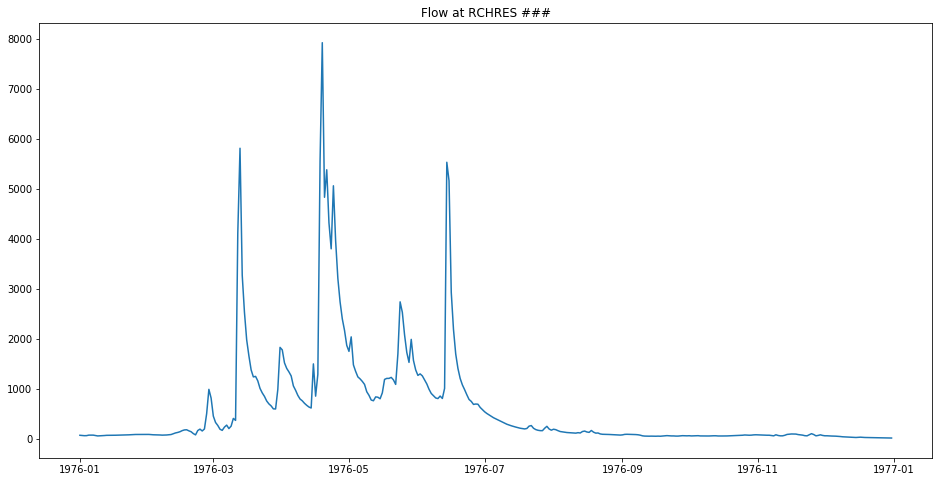

In [11]:
m_plt.figure(figsize=(16,8))
m_plt.plot(df1.resample('1D').min())
m_plt.title('Flow at RCHRES ###')